In [1]:
import argparse
import scipy.io as scio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import random
from utils import weights_init, compute_acc
from torch.utils.data import Dataset, DataLoader, TensorDataset
import os
import matplotlib.pyplot as plt
from torch.nn.utils import spectral_norm

 # 输入参数

In [289]:
parser = argparse.ArgumentParser()
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=1, help='input batch size')
parser.add_argument('--signalFeatures', type=int, default=6, help='the features of signal')
parser.add_argument('--signalPoints', type=int, default=6, help='the points of signal')
parser.add_argument('--nz', type=int, default=110, help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
parser.add_argument('--Dlr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--Glr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--netG', default='', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
parser.add_argument('--manualSeed', type=int, help='manual seed')
parser.add_argument('--num_classes', type=int, default=10, help='Number of classes for AC-GAN')
parser.add_argument('--gpu_id', type=int, default=0, help='The ID of the specified GPU')
parser.add_argument('--window', type=int, default=4, help='The size of slide window')
parser.add_argument('--slide_stride', type=int, default=1, help='The stride of slide window')
parser.add_argument('--transform', default='normalize', help='transform data')

opt = parser.parse_args(['--cuda',
                         '--batchSize','1000',
                         '--niter','500',
                         '--workers','0',
                         '--gpu_id','0',
                         '--nz','100',
                         '--num_classes','6',
                         '--signalFeatures','1',
                         '--signalPoints','6',
                         '--window','4',
                         '--slide_stride','1',
                         '--Dlr','0.01',
                         '--Glr','0.0001',
                         '--transform','maxmin'])
print(opt)

# specify the gpu id if using only 1 gpu
if opt.ngpu == 1:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(opt.gpu_id)

device = torch.device("cuda:"+str(opt.gpu_id) if torch.cuda.is_available() else "cpu")


try:
    os.makedirs(opt.outf)
except OSError:
    pass

if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
if opt.cuda:
    torch.cuda.manual_seed_all(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")


# some hyper parameters
ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)
num_classes = int(opt.num_classes)
nc = 3



Namespace(Dlr=0.01, Glr=0.0001, batchSize=1000, beta1=0.5, cuda=True, gpu_id=0, manualSeed=None, ndf=64, netD='', netG='', ngf=64, ngpu=1, niter=500, num_classes=6, nz=100, outf='.', signalFeatures=1, signalPoints=6, slide_stride=1, transform='maxmin', window=4, workers=0)
Random Seed:  9869


# 导入处理数据

In [290]:
def normalize(data):
    normalize_data = (data - data.mean(axis=0))/data.std(axis=0)
    return normalize_data

def maxmin(data):
    maxmin_data = (data - data.min())/(data.max()-data.min())
    return maxmin_data

In [291]:
data_1 = torch.from_numpy(scio.loadmat("mode_1_data.mat")['X_train']).type(torch.float32).unsqueeze(1).to(device)
data_1 = data_1[:200]
data_2 = torch.from_numpy(scio.loadmat("mode_2_data.mat")['X_train']).type(torch.float32).unsqueeze(1).to(device)
data_3 = torch.from_numpy(scio.loadmat("mode_3_data.mat")['X_train']).type(torch.float32).unsqueeze(1).to(device)
data_4 = torch.from_numpy(scio.loadmat("mode_4_data.mat")['X_train']).type(torch.float32).unsqueeze(1).to(device)
data_5 = torch.from_numpy(scio.loadmat("mode_5_data.mat")['X_train']).type(torch.float32).unsqueeze(1).to(device)
data_6 = torch.from_numpy(scio.loadmat("mode_6_data.mat")['X_train']).type(torch.float32).unsqueeze(1).to(device)


In [292]:
original_data = {0:data_1,1:data_2,2:data_3,3:data_4,4:data_5,5:data_6}
data_mean = torch.cat((data_1.mean(axis=0),data_2.mean(axis=0),data_3.mean(axis=0),data_4.mean(axis=0),data_5.mean(axis=0),data_6.mean(axis=0)),0)
data_std = torch.cat((data_1.std(axis=0),data_2.std(axis=0),data_3.std(axis=0),data_4.std(axis=0),data_5.std(axis=0),data_6.std(axis=0)),0)
data_max = torch.tensor([data_1.max(),data_2.max(),data_3.max(),data_4.max(),data_5.max(),data_6.max()]).unsqueeze(0).to(device)
data_min = torch.tensor([data_1.min(),data_2.min(),data_3.min(),data_4.min(),data_5.min(),data_6.min()]).unsqueeze(0).to(device)

## 归一化数据

In [293]:
# 对每个类别分别做了归一化，应该是错的，这样会导致分类数据混叠
# if opt.transform == 'normalize':
#     ndata_1 = normalize(data_1)
#     ndata_2 = normalize(data_2)
#     ndata_3 = normalize(data_3)
#     ndata_4 = normalize(data_4)
#     ndata_5 = normalize(data_5)
#     ndata_6 = normalize(data_6)
# elif opt.transform == 'maxmin':
#     ndata_1 = maxmin(data_1)
#     ndata_2 = maxmin(data_2)
#     ndata_3 = maxmin(data_3)
#     ndata_4 = maxmin(data_4)
#     ndata_5 = maxmin(data_5)
#     ndata_6 = maxmin(data_6)

# x_data = torch.cat((ndata_1,ndata_2,ndata_3,ndata_4,ndata_5,ndata_6),0)
# label_1 = torch.zeros(ndata_1.shape[0])
# label_2 = torch.ones(ndata_2.shape[0])
# label_3 = torch.ones(ndata_3.shape[0])*2
# label_4 = torch.ones(ndata_4.shape[0])*3
# label_5 = torch.ones(ndata_5.shape[0])*4
# label_6 = torch.ones(ndata_6.shape[0])*5
# y_data = torch.cat((label_1,label_2,label_3,label_4,label_5,label_6))

In [294]:
# 将不同类别的数据拼接
x_data = torch.cat((data_1,data_2,data_3,data_4,data_5,data_6),0)
label_1 = torch.zeros(data_1.shape[0])
label_2 = torch.ones(data_2.shape[0])
label_3 = torch.ones(data_3.shape[0])*2
label_4 = torch.ones(data_4.shape[0])*3
label_5 = torch.ones(data_5.shape[0])*4
label_6 = torch.ones(data_6.shape[0])*5
y_data = torch.cat((label_1,label_2,label_3,label_4,label_5,label_6))

tensor([0., 0., 0.,  ..., 5., 5., 5.])

In [295]:
all_data_mean = x_data.mean()
all_data_std = x_data.std()
all_data_max = x_data.max()
all_data_min = x_data.min()

if opt.transform == 'normalize':
    x_data = normalize(x_data)
elif opt.transform == 'maxmin':
    x_data = maxmin(x_data)

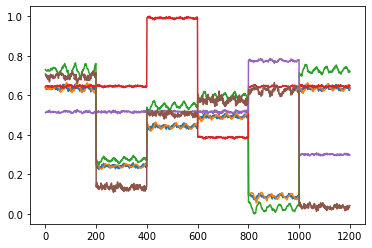

In [296]:
plt.plot(x_data.detach().cpu()[:,0,:])

In [297]:
deal_dataset = TensorDataset(x_data, y_data)
dataloader = DataLoader(dataset=deal_dataset,
                        batch_size=opt.batchSize,
                        shuffle=True,
                        num_workers=opt.workers)

In [298]:
# 定义生成器
class _netG(nn.Module):
    def __init__(self, opt):
        super().__init__()
        self.ngpu = int(opt.ngpu)
        self.nz = int(opt.nz)
        self.points = int(opt.signalPoints)
        self.batch_size = int(opt.batchSize)
        self.features = int(opt.signalFeatures)

        self.fc1 = nn.Linear(100,36)
        # output batchsize*36*1

        self.tconv2 = nn.Sequential(
            nn.ConvTranspose1d(36,18,2,1,0, bias=True),
            nn.BatchNorm1d(18),
            nn.ReLU(inplace=True)
        )# output batchsize*channel(dim)*points batchsize*18*2

        self.tconv3 = nn.Sequential(
            nn.ConvTranspose1d(18,9,2,1,0, bias=True),
            nn.BatchNorm1d(9),
            nn.ReLU(inplace=True)
        )# output batchsize*channel(dim)*points batchsize*6*4

        self.tconv4 = nn.Sequential(
            nn.ConvTranspose1d(9,opt.signalFeatures,self.points-2,1,0, bias=True),
            nn.BatchNorm1d(opt.signalFeatures),
            nn.ReLU(inplace=True)
        )# output batchsize*channel(dim)*points batchsize*9*3

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            input = input.view(-1, self.nz)
            fc1 = nn.parallel.data_parallel(self.fc1, input, range(self.ngpu))
            fc1 = fc1.view(-1, 36, 1)
            tconv2 = nn.parallel.data_parallel(self.tconv2, fc1, range(self.ngpu))
            tconv3 = nn.parallel.data_parallel(self.tconv3, tconv2, range(self.ngpu))
            tconv4 = nn.parallel.data_parallel(self.tconv4, tconv3, range(self.ngpu))
            output = tconv4
        else:
            input = input.view(-1, self.nz)
            fc1 = self.fc1(input)
            fc1 = fc1.view(-1, 36, 1)
            tconv2 = self.tconv2(fc1)
            tconv3 = self.tconv3(tconv2)
            tconv4 = self.tconv4(tconv3)
            output = tconv4
        return output



In [299]:
# 定义鉴别器
class _netD(nn.Module):
    def __init__(self, opt):
        super().__init__()
        self.ngpu = int(opt.ngpu)
        self.num_classes = opt.num_classes
        self.points = int(opt.signalPoints)
        self.features = int(opt.signalFeatures)

        self.conv1 = nn.Sequential(
            nn.Conv1d(opt.signalFeatures,12,2,1,0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.8, inplace=False)
        )# output [1, 12, 3]
        self.conv2 = nn.Sequential(
            nn.Conv1d(12,24,2,1,0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.8, inplace=False)
        )# output [1, 24, 1]
        self.conv3 = nn.Sequential(
            nn.Conv1d(24,48,2,1,0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.8, inplace=False)
        )# output [1, 48, 1]

        self.fc_dis = spectral_norm(nn.Linear(48*(self.points-3), 1))
        self.fc_aux = spectral_norm(nn.Linear(48*(self.points-3), self.num_classes))
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        batchsize = input.shape[0]
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            conv1 = nn.parallel.data_parallel(self.conv1, input, range(self.ngpu))
            conv2 = nn.parallel.data_parallel(self.conv2, conv1, range(self.ngpu))
            conv3 = nn.parallel.data_parallel(self.conv3, conv2, range(self.ngpu))
            flat = conv3.view(-1, 48*1)
            fc_dis = nn.parallel.data_parallel(self.fc_dis, flat, range(self.ngpu))
            fc_aux = nn.parallel.data_parallel(self.fc_aux, flat, range(self.ngpu))
        else:
            conv1 = self.conv1(input)
            conv2 = self.conv2(conv1)
            conv3 = self.conv3(conv2)
            flat = conv3.view(batchsize, -1)
            fc_dis = self.fc_dis(flat)
            fc_aux = self.fc_aux(flat)
        classes = self.softmax(fc_aux)
        realfake = self.sigmoid(fc_dis).view(-1, 1).squeeze(1)
        return realfake, classes



In [300]:
# 初始化生成器和鉴别器
netG = _netG(opt).to(device)
netG.apply(weights_init)
netD = _netD(opt).to(device)
netD.apply(weights_init)


_netD(
  (conv1): Sequential(
    (0): Conv1d(1, 12, kernel_size=(2,), stride=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.8, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(12, 24, kernel_size=(2,), stride=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.8, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv1d(24, 48, kernel_size=(2,), stride=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.8, inplace=False)
  )
  (fc_dis): Linear(in_features=144, out_features=1, bias=True)
  (fc_aux): Linear(in_features=144, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
  (sigmoid): Sigmoid()
)

In [301]:
# 定义鉴别和辅助分类损失函数
dis_criterion = nn.BCELoss().to(device)
aux_criterion = nn.CrossEntropyLoss().to(device)


 # 定义优化器

In [302]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.Dlr, betas=(opt.beta1, 0.999))
optimizerG = optim.RMSprop(netG.parameters(), lr=opt.Glr)


 # 训练

 # 初始化变量

In [303]:
# tensor placeholders
noise = torch.FloatTensor(opt.batchSize, nz, 1).to(device)
dis_label = torch.FloatTensor(opt.batchSize).to(device)
aux_label = torch.LongTensor(opt.batchSize).to(device)
D_real_label = 1
# D_real_label = 0.9+random.random()/10
G_real_label = 1
fake_label = 0
# fake_label = random.random()/10

In [304]:
avg_loss_D = 0.0
avg_loss_G = 0.0
avg_loss_A = 0.0

In [305]:
aux_loss_coef = 1

In [314]:
for epoch in range(opt.niter):
# for epoch in range(5000):
    for i, data in enumerate(dataloader, 0):
        if epoch==400:
            pass

        #############################
        ## (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        #############################
        # train with real
        netD.zero_grad()
        real_cpu, label = data
        input_samples = real_cpu
        batch_size = real_cpu.shape[0]
        dis_label.resize_(batch_size).fill_(D_real_label)
        # dis_label[:int(opt.batchSize*0.1)] = 0  # 翻转部分标签

        aux_label.resize_(batch_size).copy_(label)
        dis_output, aux_output = netD(input_samples)

        dis_errD_real = dis_criterion(dis_output, dis_label)
        aux_errD_real = aux_criterion(aux_output, aux_label)
        errD_real = (dis_errD_real + aux_loss_coef*aux_errD_real)/4
        errD_real.backward()
        D_x = dis_output.mean()

        # compute the current classification accuracy
        accuracy = compute_acc(aux_output, aux_label)

        # train with fake
        label = torch.randint_like(aux_label, 0, num_classes)
        noise = torch.randn(batch_size, nz,1,1).to(device)
        class_onehot = torch.zeros((batch_size, num_classes)).to(device)
        class_onehot[np.arange(batch_size), label] = 1
        noise[np.arange(batch_size), :num_classes, 0, 0] = class_onehot[np.arange(batch_size)]
        aux_label.copy_(label)

        fake = netG(noise)
        dis_label.fill_(fake_label)
        dis_output, aux_output = netD(fake.detach())
        dis_errD_fake = dis_criterion(dis_output, dis_label)
        aux_errD_fake = aux_criterion(aux_output, aux_label)
        errD_fake = (dis_errD_fake + aux_loss_coef*aux_errD_fake)/4
        errD_fake.backward()
        D_G_z1 = dis_output.mean()
        errD = (errD_real + errD_fake)/4
        optimizerD.step()

        #############################
        ## (2) Update G network: maximize log(D(G(z)))
        #############################
        if epoch >5:
            G_more = 0
            if G_more:
                for Gj in range(5):
                    label = torch.randint_like(aux_label, 0, num_classes)
                    noise = torch.randn(batch_size, nz,1,1).to(device)
                    class_onehot = torch.zeros((batch_size, num_classes)).to(device)
                    class_onehot[np.arange(batch_size), label] = 1
                    noise[np.arange(batch_size), :num_classes, 0, 0] = class_onehot[np.arange(batch_size)]
                    aux_label.copy_(label)

                    fake = netG(noise)
                    netG.zero_grad()
                    dis_label.fill_(G_real_label)
                    dis_output, aux_output = netD(fake)
                    dis_errG = dis_criterion(dis_output, dis_label)
                    aux_errG = aux_criterion(aux_output, aux_label)
                    errG = (dis_errG + aux_loss_coef*aux_errG)/2
                    errG.backward()
                    D_G_z2 = dis_output.mean()
                    optimizerG.step()
            else:
                netG.zero_grad()
                dis_label.fill_(G_real_label)
                dis_output, aux_output = netD(fake)
                dis_errG = dis_criterion(dis_output, dis_label)
                aux_errG = aux_criterion(aux_output, aux_label)
                errG = (dis_errG + aux_loss_coef*aux_errG)/2
                errG.backward()
                D_G_z2 = dis_output.mean()
                optimizerG.step()


        # compute the average loss
        curr_iter = 1
        all_loss_G = avg_loss_G * curr_iter
        all_loss_D = avg_loss_D * curr_iter
        all_loss_A = avg_loss_A * curr_iter
        all_loss_G += errG.item()
        all_loss_D += errD.item()
        all_loss_A += accuracy
        avg_loss_G = all_loss_G / (curr_iter + 1)
        avg_loss_D = all_loss_D / (curr_iter + 1)
        avg_loss_A = all_loss_A / (curr_iter + 1)
        print('[%d/%d][%d/%d] Loss_D: %.4f (%.4f) Loss_G: %.4f (%.4f) D(x): %.4f D(G(z)): %.4f / %.4f Acc: %.4f (%.4f)'
                % (epoch, opt.niter, i, len(dataloader),
                errD.item(), avg_loss_D, errG.item(), avg_loss_G, D_x, D_G_z1, D_G_z2, accuracy, avg_loss_A))



497 / 0.3484 Acc: 40.4000 (40.5127)
[419/500][1/2] Loss_D: 0.0916 (0.0893) Loss_G: 4.1692 (4.1042) D(x): 0.6115 D(G(z)): 0.3513 / 0.3419 Acc: 36.0000 (38.2564)
[420/500][0/2] Loss_D: 0.0875 (0.0884) Loss_G: 3.1621 (3.6331) D(x): 0.6362 D(G(z)): 0.3483 / 0.3546 Acc: 39.4000 (38.8282)
[420/500][1/2] Loss_D: 0.0877 (0.0881) Loss_G: 4.2827 (3.9579) D(x): 0.6252 D(G(z)): 0.3515 / 0.3475 Acc: 47.5000 (43.1641)
[421/500][0/2] Loss_D: 0.0865 (0.0873) Loss_G: 3.3077 (3.6328) D(x): 0.6388 D(G(z)): 0.3516 / 0.3656 Acc: 40.8000 (41.9820)
[421/500][1/2] Loss_D: 0.0879 (0.0876) Loss_G: 3.2692 (3.4510) D(x): 0.6561 D(G(z)): 0.3503 / 0.3290 Acc: 35.0000 (38.4910)
[422/500][0/2] Loss_D: 0.0802 (0.0839) Loss_G: 4.2576 (3.8543) D(x): 0.6437 D(G(z)): 0.2919 / 0.2863 Acc: 37.2000 (37.8455)
[422/500][1/2] Loss_D: 0.0806 (0.0823) Loss_G: 4.7630 (4.3086) D(x): 0.6712 D(G(z)): 0.3310 / 0.3470 Acc: 35.5000 (36.6728)
[423/500][0/2] Loss_D: 0.0862 (0.0842) Loss_G: 3.5509 (3.9297) D(x): 0.6695 D(G(z)): 0.3659 / 0.

In [315]:
netD.zero_grad()
real_cpu, label = data
input_samples = real_cpu
batch_size = real_cpu.shape[0]
dis_label.resize_(batch_size).fill_(D_real_label)
# dis_label[:int(opt.batchSize*0.1)] = 0  # 翻转部分标签

aux_label.resize_(batch_size).copy_(label)
dis_output, aux_output = netD(input_samples)

In [316]:
dis_output

tensor([0.3398, 0.7911, 0.4250, 0.6167, 0.4050, 0.9994, 0.7454, 0.4312, 0.9359,
        0.7530, 0.4533, 0.3640, 0.3814, 0.6366, 0.5352, 0.3793, 0.6896, 0.4180,
        0.7610, 0.5628, 0.4191, 0.7345, 0.9991, 0.8159, 0.5288, 0.9987, 0.9545,
        0.2789, 0.6350, 0.9639, 0.5824, 0.9581, 0.4819, 0.2219, 0.2571, 0.4689,
        0.5696, 0.9571, 0.3948, 0.9886, 0.3110, 1.0000, 0.6691, 0.2211, 0.9995,
        0.5521, 0.9686, 0.9898, 0.9446, 0.9963, 0.4195, 0.6443, 0.4200, 0.5452,
        0.9896, 0.4123, 0.3241, 0.7492, 0.9998, 0.5125, 0.6967, 0.6374, 0.4825,
        0.9507, 0.3477, 0.4266, 0.8935, 0.5725, 0.7289, 0.4244, 0.7600, 0.3066,
        0.4997, 0.4823, 0.4197, 0.9556, 0.3731, 0.6819, 0.9444, 0.9037, 0.2595,
        0.8779, 0.9611, 0.7542, 0.7683, 0.2978, 0.9482, 0.7522, 0.3242, 0.5873,
        0.6525, 0.9502, 0.8893, 0.7984, 0.2182, 0.2899, 0.6840, 0.8894, 0.4614,
        0.9303, 0.2684, 0.9401, 0.7956, 0.6673, 0.4103, 0.9779, 0.6713, 0.9563,
        0.8999, 0.4385, 0.8603, 0.5613, 

In [317]:
aux_output.max(axis=1)[1]-aux_label

tensor([ 0,  4, -2,  0,  0,  2, -1, -3,  0, -3,  0,  0,  0,  2,  0,  0,  0,  0,
         0, -1,  0,  3, -3,  0, -2, -2,  0,  0,  0,  0,  0,  0,  2,  0,  3,  0,
         0,  0, -3, -2,  0,  0,  0,  0, -5,  0,  2,  3, -5,  0,  0, -2,  0,  1,
         3, -4,  0,  0,  5,  2,  0,  1,  0,  0,  0,  0,  2,  0, -3,  4,  0, -4,
         2,  0,  0,  5, -1, -2,  0,  0,  2,  0,  0,  1,  0, -2,  0,  3, -1,  0,
         1,  0,  2,  5,  0,  0, -3,  1, -3,  0,  0,  5,  1,  1,  0,  0, -3, -3,
         0, -2,  5,  3,  0, -1, -2,  0, -1,  0,  0, -4,  0,  2, -4,  0,  0,  0,
         0,  0, -2,  0,  0, -1, -2,  0,  0, -3, -3,  0, -3,  2,  2,  3, -2, -1,
         2,  3,  0, -2,  3,  0,  0,  1, -3,  1, -3,  3,  0,  0,  3, -2,  0,  0,
        -3,  0,  2,  1, -2,  0,  4,  0,  2,  0,  1,  0,  1,  3,  0, -4,  0,  0,
         1,  0, -4,  1,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0, -3, -2,  3, -3,
         1,  0], device='cuda:0')

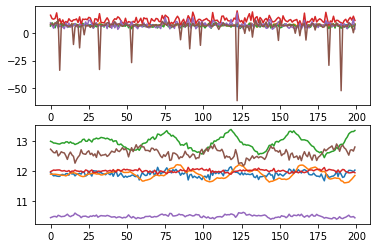

In [326]:
label = torch.randint_like(aux_label, 0, num_classes)
dim = 0
label[:] = dim
noise = torch.randn(batch_size, nz,1,1).to(device)
class_onehot = torch.zeros((batch_size, num_classes)).to(device)
class_onehot[np.arange(batch_size), label] = 1
noise[np.arange(batch_size), :num_classes, 0, 0] = class_onehot[np.arange(batch_size)]
aux_label.copy_(label)

fake = netG(noise)
if opt.transform == 'normalize':
    # fake = fake*data_std[dim]+data_mean[dim]
    fake = fake*all_data_std + all_data_mean
elif opt.transform == 'maxmin':
    fake = fake*(all_data_max-all_data_min)+all_data_min

plot_fake_sample = fake.permute(0,2,1).detach().cpu()
plt.figure()
plt.subplot(2,1,1)
plt.plot(plot_fake_sample[:,:,0])
plt.subplot(2,1,2)
plt.plot(original_data[dim][:,0,:].detach().cpu())
plt.savefig('fig1.png')

In [311]:
torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))

tensor(1.)

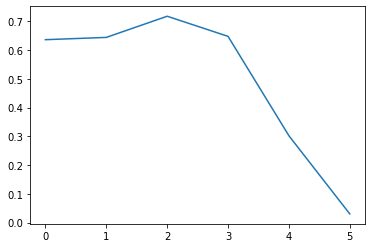

In [312]:
sample_plot = 7
plt.figure()
plt.plot((data[0][2].view(-1,1).detach().cpu()).numpy())
data[1][sample_plot]

In [313]:
data[1]

tensor([2., 3., 5., 5., 2., 1., 2., 1., 4., 5., 2., 5., 1., 0., 2., 5., 1., 0.,
        4., 4., 2., 2., 1., 4., 5., 3., 1., 3., 5., 2., 0., 5., 0., 2., 0., 3.,
        1., 5., 5., 3., 5., 1., 4., 4., 2., 0., 2., 2., 3., 2., 5., 0., 5., 0.,
        0., 1., 0., 0., 3., 2., 4., 0., 2., 3., 5., 0., 4., 1., 3., 4., 5., 2.,
        4., 3., 0., 2., 1., 2., 1., 0., 1., 3., 5., 4., 5., 3., 3., 5., 2., 3.,
        5., 1., 3., 2., 0., 5., 0., 3., 1., 4., 2., 3., 3., 3., 0., 0., 3., 3.,
        5., 2., 3., 3., 0., 1., 4., 4., 4., 2., 3., 1., 3., 2., 3., 2., 4., 2.,
        0., 5., 3., 5., 3., 3., 5., 1., 3., 3., 3., 1., 3., 0., 3., 4., 1., 4.,
        2., 3., 1., 3., 2., 0., 2., 2., 5., 5., 0., 0., 1., 0., 3., 0., 2., 0.,
        4., 5., 3., 3., 3., 5., 2., 5., 5., 0., 0., 5., 3., 1., 3., 1., 4., 2.,
        3., 5., 3., 5., 0., 0., 0., 2., 1., 0., 4., 4., 4., 2., 0., 2., 5., 0.,
        3., 5.])